# Wine pairing
Zuzanna Gawrysiak 148255, Agata Żywot 148258


Goal of the project:
1. Adding flavor information (sweet, acid, salt, piquant, fat, bitter) from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews to FlavorGraph.
2. Utilizing embeddings and flavors for pairing with wine from https://www.kaggle.com/datasets/roaldschuring/wine-reviews.

### Import necessary libraries

In [1]:
import sys
sys.path.append('../')

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import spatial

from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser

from src.consts.food import CORE_TASTES
from src.data_preprocessing.text_preprocessing import (
    read_csv_to_list_of_lists,
    normalize_sentences, 
    extract_phrases,
    extract_phrases,
    normalize_sentences,
    preprocess_food_list,
    make_food_embedding_dict,
    compute_core_tastes_embeddings,
    compute_core_tastes_distances,
    get_food_nonaroma_info,
)

### Dataset - [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)

In [2]:
food_reviews_df = pd.read_csv('../data/Reviews.csv')
display(food_reviews_df.head(3))
print(food_reviews_df.shape)
print(f"All rows have a review: {food_reviews_df.Text.notnull().all()}")

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


(568454, 10)
All rows have a review: True


One can see most of rating scores are 5s - due to this fact we assume the information about rich flavors can be found in the reviews text.

In [4]:
food_reviews_df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [15]:
# Print top 10 most frequent words
top_words = pd.Series(' '.join(food_reviews_df["Text"]).split()).value_counts()
top_words[:10]

the    1628045
I      1388076
and    1228666
a      1163164
to      992367
of      789652
is      714264
it      631252
for     519983
in      512394
Name: count, dtype: int64

### Reviews

In [17]:
reviews_list = [str(r) for r in list(food_reviews_df['Text'])]
reviews_list[:5]

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
 'If you are looking f

Tokenize and normalize

In [19]:
# use sentence tokenizer to split the reviews into sentences
food_reviews_corpus = ' '.join(reviews_list)
food_reviews_corpus_tokenized = sent_tokenize(food_reviews_corpus)
food_reviews_corpus_tokenized[:5]

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality.',
 'The product looks more like a stew than a processed meat and it smells better.',
 'My Labrador is finicky and she appreciates this product better than  most.',
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted.',
 'Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".']

In [37]:
food_reviews_normalized = normalize_sentences(food_reviews_corpus_tokenized)
food_reviews_normalized[:3]

[['bought',
  'sever',
  'vital',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'qualiti'],
 ['product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better'],
 ['labrador', 'finicki', 'appreci', 'product', 'better']]

Extract n-grams

In [38]:
# extract the most relevant bi- and tri-grams
food_phrases = extract_phrases(food_reviews_normalized, save_path="../data/food_trigrams.pkl")
food_phrases[0]

['bought',
 'sever',
 'vital',
 'dog',
 'food',
 'product',
 'found',
 'good',
 'qualiti']

In [39]:
with open("../data/food_phrases.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(food_phrases)

Stats (wordmap)

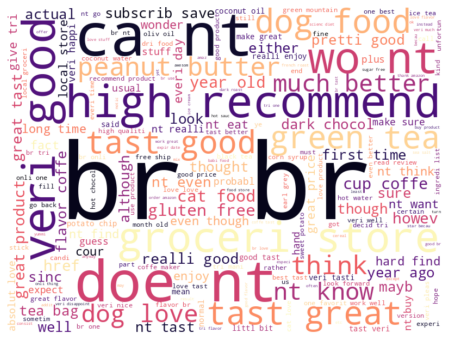

In [41]:
words_all = [word for sublist in food_reviews_normalized for word in sublist]
words_all_text = " ".join(words_all)

wc = WordCloud(
    width=800, height=600, max_words=200, background_color="white", colormap="magma"
).generate(words_all_text)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data preprocessing

In [5]:
food_df = pd.read_csv("../data/list_of_foods.csv")
food_list = list(food_df["Food"])
print(food_list[:5])

['acorn squash', 'Aguachile', 'Aïoli\xa0', 'Albóndigas', 'Alegrías']


In [2]:
# load trigram and word2vec models
food_phrases = read_csv_to_list_of_lists("../data/food_phrases.csv")
food_trigram_model = Phraser.load("../data/food_trigrams.pkl")

# TODO: fix this
# model_path = "../data/word2vec.bin"
# wine_word2vec_model = Word2Vec.load(model_path)

In [6]:
food_list_preprocessed = preprocess_food_list(food_list, food_trigram_model)
food_list_preprocessed[:10]

['squid',
 'selfrais',
 'lettuc',
 'licoric',
 'pork',
 'bistec',
 'chilaquil',
 'cranberri',
 'tapioca',
 'coleslaw']

In [ ]:
food_embedding_dict = make_food_embedding_dict(food_list_preprocessed, wine_word2vec_model)
food_embedding_dict

In [ ]:
core_tastes_embeddings = compute_core_tastes_embeddings(wine_word2vec_model)
core_tastes_distances = compute_core_tastes_distances(food_embedding_dict, core_tastes_embeddings)

In [ ]:
food_nonaroma_info_df = get_food_nonaroma_info(core_tastes_distances, core_tastes_embeddings, verbose=True)
food_nonaroma_info_df.to_csv("../data/food_nonaroma_info.csv")